In [1]:
import keras
from keras.applications import inception_v3
from keras import backend as K
K.set_learning_phase(0)
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

Using TensorFlow backend.


87916544/87910968 [==============================] - 16s 0us/step


In [18]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
coeff = 0.2
activation = layer_dict['mixed2'].output
scaling = K.prod(K.cast(K.shape(activation), 'float32'))
loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [19]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [20]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

In [21]:
import numpy as np
step = 0.01
num_octave = 5
octave_scale = 1.7
iterations = 25
max_loss = 10.
base_image_path = '/Users/Ms_lililizi/Desktop/deep_learning.png'
img = image.load_img(base_image_path)
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = inception_v3.preprocess_input(img)
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    x = np.copy(img)
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    pil_img = np.clip(x, 0, 255).astype('uint8')
    fname='dream_at_scale_' + str(shape) + '.png'
    scipy.misc.imsave(fname, pil_img)
x = np.copy(img)
if K.image_data_format() == 'channels_first':
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose((1, 2, 0))
else:
    x = x.reshape((x.shape[1], x.shape[2], 3))
x /= 2.
x += 0.5
x *= 255.
pil_img = np.clip(x, 0, 255).astype('uint8')
fname ='final_dream.png'
scipy.misc.imsave(fname, pil_img)


Processing image shape (171, 306)
...Loss value at 0 : 0.0590127
...Loss value at 1 : 0.0714047
...Loss value at 2 : 0.0884814
...Loss value at 3 : 0.105518
...Loss value at 4 : 0.120828
...Loss value at 5 : 0.135959
...Loss value at 6 : 0.15008
...Loss value at 7 : 0.164496
...Loss value at 8 : 0.177118
...Loss value at 9 : 0.189529
...Loss value at 10 : 0.200437
...Loss value at 11 : 0.212518
...Loss value at 12 : 0.222474
...Loss value at 13 : 0.231735
...Loss value at 14 : 0.242349
...Loss value at 15 : 0.251785
...Loss value at 16 : 0.260643
...Loss value at 17 : 0.269353
...Loss value at 18 : 0.277697
...Loss value at 19 : 0.285505
...Loss value at 20 : 0.293962
...Loss value at 21 : 0.301761
...Loss value at 22 : 0.308907
...Loss value at 23 : 0.316276
...Loss value at 24 : 0.324031
Processing image shape (292, 521)
...Loss value at 0 : 0.0834994
...Loss value at 1 : 0.106487
...Loss value at 2 : 0.124958
...Loss value at 3 : 0.141409
...Loss value at 4 : 0.157645
...Loss value 

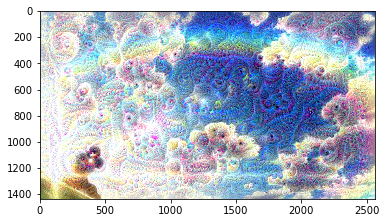

In [22]:
from matplotlib import pyplot as plt
x = np.copy(img)
if K.image_data_format() == 'channels_first':
    x = x.reshape((3, x.shape[2], x.shape[3]))
    x = x.transpose((1, 2, 0))
else:
    x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    final = np.clip(x, 0, 255).astype('uint8')
plt.imshow(final)
plt.show()